In [ ]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

start_date = ow.DateObj(2008, 1, 1)
end_date = ow.DateObj(2020, 12, 31)
save_type = ow.SaveType.PICKLE
stock = 'NDQ'
universe = ow.Universe([stock])


In [ ]:
delta_tol = 0.02

atm_spec = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 60) and (t <= 150),
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) >= 0.45 - delta_tol) and (abs(d) <= 0.45 + delta_tol),
    entry_min="perc_spread",
    max_hold_period=30,
    position = -1.0
)


# --- OTM leg spec ---
otm_spec = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 60) and (t <= 150),
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) <= 0.1 + delta_tol) and (abs(d) >= 0.1 - delta_tol),
    entry_min="perc_spread",
    max_hold_period=30,
    position = 2.0
)

specs = [atm_spec, otm_spec]

In [ ]:
from functools import partial
from operator import le, eq

suffix = "30_10_1x2.5"


pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['call_put', 'ttm', 'n_missing'],
    'keep_oper': [eq, le, le],
    'keep_val': ['p', 150, 0],
    'specs': specs,
    'hold_period': 30,
    'protected_notional': 1_000_000,
    'suffix': suffix
    }

ow.wrap_fn = partial(ow.wrap_fn, pipeline=pipeline, kwargs=kwargs)
ow.add_idx_spread_methods(pipeline, kwargs)


In [ ]:
pipeline.run()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:12<00:00, 72.93s/it]


In [ ]:
import options_wizard as ow
from functools import partial

start_cash = 1_000_000


ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.MTM
)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs
)
position = ow.FixedHoldNotional(cfg)

strat = ow.StratType.load(stock, save_type=save_type, suffix=suffix)  
trades = strat.reconstruct(ptf)
position.add_trade(trades)

In [ ]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

 36%|███▌      | 1165/3274 [00:02<00:04, 506.96it/s]C:\Users\cameronA\Desktop\options_wizard\src\backtest\coordinator.py:64: RuntimeWarning: invalid value encountered in log
  self._returns.append(np_log(position / current_equity))
100%|██████████| 3274/3274 [00:07<00:00, 441.80it/s]


C:\Users\cameronA\AppData\Local\Temp\ipykernel_37968\3463874869.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


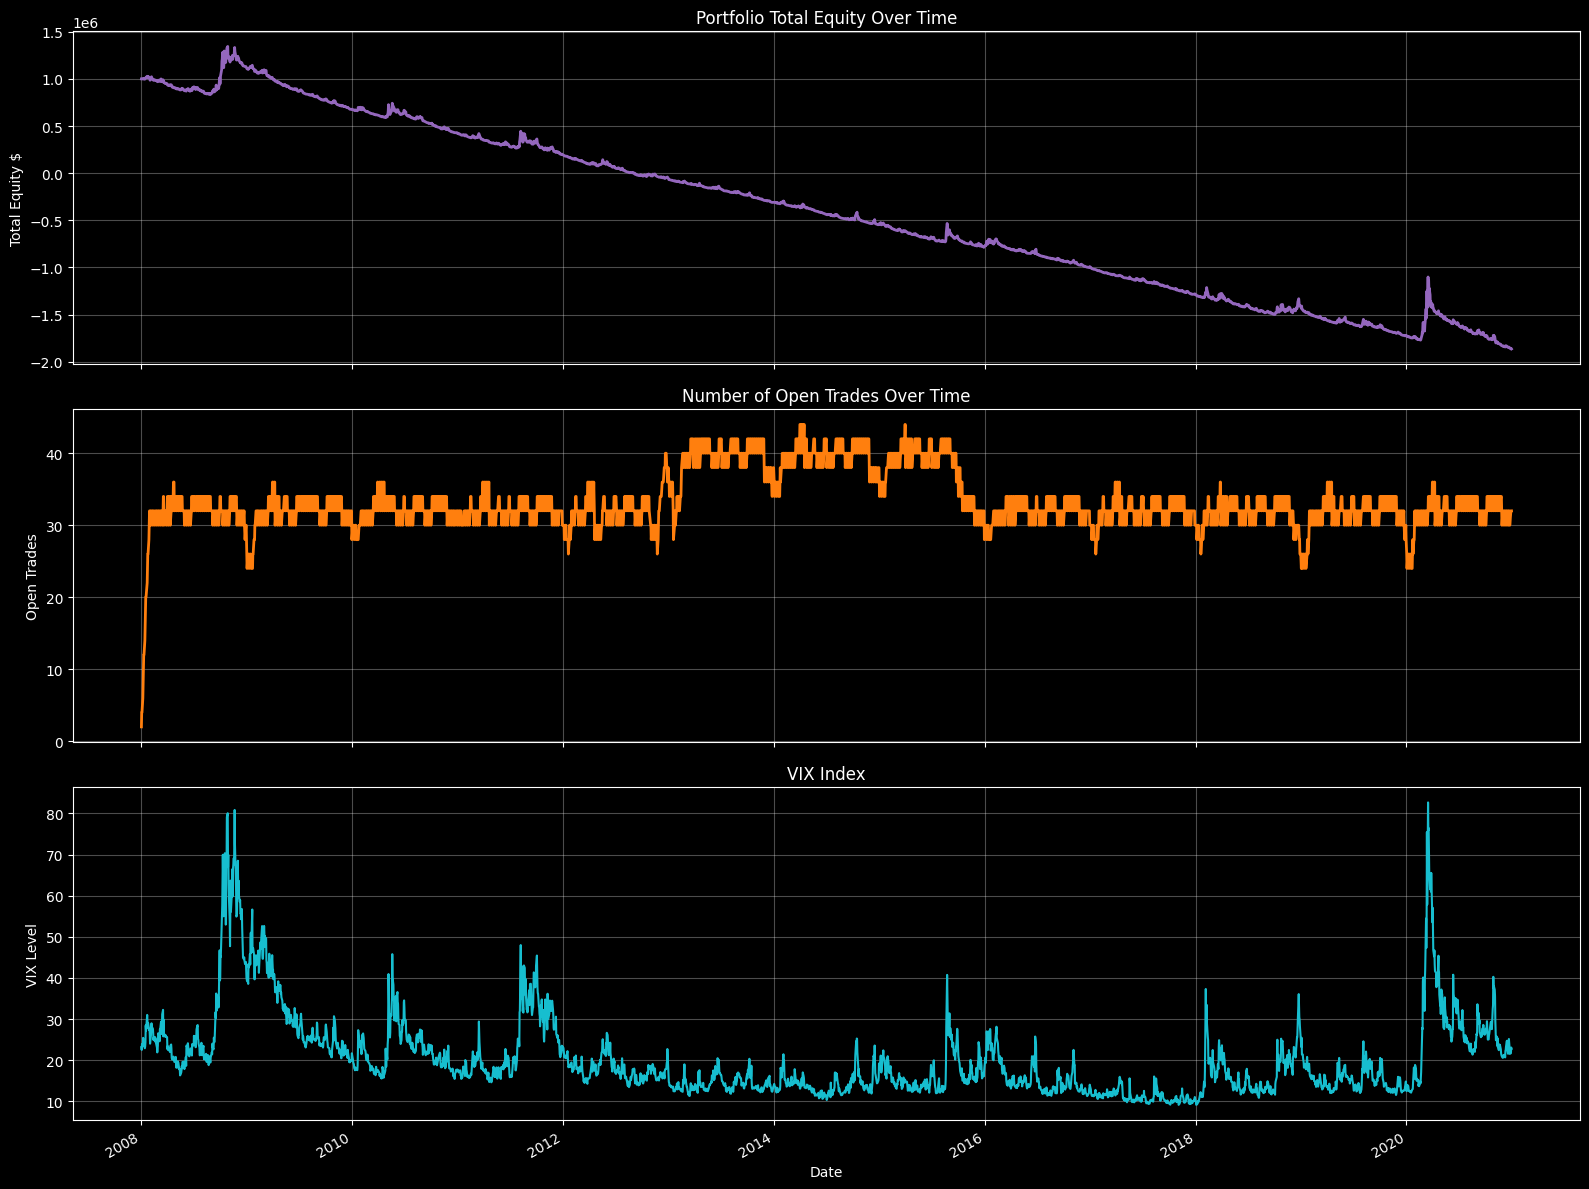

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotx
import matplotlib

matplotlib.style.use('dark_background')


# ---------------------------
# Existing data
# ---------------------------
equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])
dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

start_date = dates.min()
end_date = dates.max()

# ---------------------------
# Fetch VIX data
# ---------------------------
vix = yf.download("^VIX", start=start_date, end=end_date)
vix_dates = vix.index.to_pydatetime()
vix_close = vix["Close"].to_numpy()

dates = dates[:-1]
equity = equity[:-1]
n_trades = n_trades[:-1]

# ---------------------------
# Plotting
# ---------------------------
fig, axes = plt.subplots(
    3, 1, figsize=(16, 12), sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 1]}
)

# --- Total Equity ---
axes[0].plot(dates, equity, color="tab:purple", lw=2)
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Portfolio Total Equity Over Time")
axes[0].set_ylabel("Total Equity $")

# --- Number of Open Trades ---
axes[1].plot(dates, n_trades, color="tab:orange", lw=2)
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Number of Open Trades Over Time")
axes[1].set_ylabel("Open Trades")

# --- VIX ---
axes[2].plot(vix_dates, vix_close, color="tab:cyan", lw=1.5)
axes[2].grid(True, alpha=0.3)
axes[2].set_title("VIX Index")
axes[2].set_ylabel("VIX Level")
axes[2].set_xlabel("Date")

# Improve date formatting
fig.autofmt_xdate()

plt.tight_layout()
plt.show()
